# Clustering Models

### Contents:
- [Imports](#Imports)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Vectorizing and Modeling](#Vectorizing-and-Modeling)
- [Bringing in Bot Rating Data](#Bringing-in-Bot-Rating-Data)

## Imports 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from nltk.tokenize import RegexpTokenizer
import numpy as np
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster,cophenet
from pylab import rcParams
import seaborn as sns

## Exploratory Data Analysis

**Reading the data and initial cleaning steps:**

In [11]:
# Reading in the data. Note to team: I had to go back to the original data to have a dataframe 
# that separates mentions, user id and text. 
twitter_firesv = pd.read_csv('./data/tweets_raw.csv')

In [12]:
# Taking a first glance 
twitter_firesv.head()

,0,1,2,3,4,5,6,7,8,9
0,2019-11-29 23:10:01+00:00,California Wildfires Inspire Entrepreneur to C...,ReginaBanali,1200552524291411970,https://twitter.com/ReginaBanali/status/120055...,NaN,0,0,NaN,NaN
1,2019-11-29 22:49:52+00:00,NEW! ‘Rage for Justice Report - Episode 2 How ...,ConsumerWD,1200547453948162048,https://twitter.com/ConsumerWD/status/12005474...,NaN,0,0,@PGE4Me @californiapuc,#californiawildfires #pge #FridayThoughts #Fri...
2,2019-11-29 22:46:00+00:00,With the #CaliforniaWildFires fresh in our min...,ChangeTheLAUSD,1200546481494577153,https://twitter.com/ChangeTheLAUSD/status/1200...,GOPChairwoman,0,2,@KatieHill4CA,#CaliforniaWildFires #GOPTaxScam
3,2019-11-29 22:08:21+00:00,#climate “Each degree of warming causes way mo...,ECOWARRIORSS,1200537005396037632,https://twitter.com/ECOWARRIORSS/status/120053...,NaN,17,15,@yayitsrob,#climate
4,2019-11-29 22:08:07+00:00,The California wildfires should come to SoHo,jamesdotcom,1200536945711108104,https://twitter.com/jamesdotcom/status/1200536...,NaN,1,19,NaN,NaN


In [13]:
# Changing titles 
twitter_firesv.rename(columns={
     '0': 'date',
     '1' : 'text',
     '2' : 'username',
     '3' : 'id',
     '4' : 'link',
     '5' : 'tweet_to',
     '6' : 'times_retweeted',
     '7' : 'times_favorited',
     '8' : 'mentions',
     '9' : 'hashtags'
}, inplace=True)

In [14]:
twitter_firesv.head(1)

,date,text,username,id,link,tweet_to,times_retweeted,times_favorited,mentions,hashtags
0,2019-11-29 23:10:01+00:00,California Wildfires Inspire Entrepreneur to C...,ReginaBanali,1200552524291411970,https://twitter.com/ReginaBanali/status/120055...,NaN,0,0,NaN,NaN


In [15]:
# Dropping link as we won't need it 
twitter_firesv.drop(columns=['link'], inplace=True)

In [16]:
twitter_firesv.head(1)

,date,text,username,id,tweet_to,times_retweeted,times_favorited,mentions,hashtags
0,2019-11-29 23:10:01+00:00,California Wildfires Inspire Entrepreneur to C...,ReginaBanali,1200552524291411970,NaN,0,0,NaN,NaN


**Feature ingeneering: 'tweet_to'+ 'mentions':**

In [17]:
# Looking at tweet_to. This column shows the destinatary of a public tweet reply
twitter_firesv['tweet_to'].value_counts()

realDonaldTrump    293
GavinNewsom         89
ABC                 42
latimes             35
BreitbartNews       30
                  ... 
archillect           1
shopelasticco        1
CNNPolitics          1
real_defender        1
Parisire             1
Name: tweet_to, Length: 2505, dtype: int64

In [18]:
# Looking at mentions. This column shows the twitter handles mentioned/brought up in the text 
twitter_firesv['mentions'].value_counts()

@YouTube                             440
@realDonaldTrump                     253
@NBCNews                             178
@ABC                                 175
@googlenews                          114
                                    ... 
@GettyMuseum @discoverLA @VisitCA      1
@manilabulletin                        1
@NBCLA @CBSLA @ABC @KTLA @KTLA         1
@Michele_NFPA @HazCenter               1
@laurenTarshis                         1
Name: mentions, Length: 2395, dtype: int64

In [19]:
# Replacing all null values with zero as all correspond to information being not applicable. 
twitter_firesv.fillna(0, inplace=True)

In [20]:
# I am merging 'tweet_to' and 'mentions' under the assumption that both relate to an intended addressee 
twitter_firesv['addressee'] = twitter_firesv['tweet_to'].astype(str) + ' ' + twitter_firesv['mentions'].astype(str)

In [21]:
twitter_firesv[twitter_firesv['tweet_to'] != 0]

,date,text,username,id,tweet_to,times_retweeted,times_favorited,mentions,hashtags,addressee
2,2019-11-29 22:46:00+00:00,With the #CaliforniaWildFires fresh in our min...,ChangeTheLAUSD,1200546481494577153,GOPChairwoman,0,2,@KatieHill4CA,#CaliforniaWildFires #GOPTaxScam,GOPChairwoman @KatieHill4CA
8,2019-11-29 20:34:20+00:00,You’re out of control. I’m surprised the far r...,Clementine5000,1200513345973104646,TweetOfMoses_,0,1,0,0,TweetOfMoses_ 0
10,2019-11-29 19:54:46+00:00,@DavidCayJ on PG&amp;E's role in devastation c...,RainMaki,1200503388443688960,DavidCayJ,0,2,@DavidCayJ @KatyTurNBC @MSNBC,#California #Wildfires #ClimateChange #MSNBC #...,DavidCayJ @DavidCayJ @KatyTurNBC @MSNBC
15,2019-11-29 19:13:13+00:00,Yes. And don't forget that the massive Califor...,SmartmanAZ,1200492930114490368,Atlantiso1,0,1,0,0,Atlantiso1 0
19,2019-11-29 16:28:50+00:00,"Relocation of patriots, like California wildfi...",aubresdelnoire,1200451561408872448,IPOT1776,0,0,0,0,IPOT1776 0
...,...,...,...,...,...,...,...,...,...,...
28463,2019-10-02 21:15:41+00:00,All these blogs gonna spread th hat shit like ...,RAMBOHUSTLE,1179505256297881601,HustleSimmons,0,0,0,0,HustleSimmons 0
28464,2019-10-02 20:09:43+00:00,They were having such a nice conversation abou...,TheOrdBarroness,1179488651467792385,swimmerbr78,0,1,0,0,swimmerbr78 0
28470,2019-10-02 01:10:02+00:00,That dumbass didn't even know AILD donated a p...,rocknroro,1179201841420259328,lambgoat,0,0,0,0,lambgoat 0
28472,2019-10-01 22:29:56+00:00,California is known to have bimodal fire seaso...,EdJoyce,1179161552793952256,NWSLosAngeles,0,2,0,#USwildfires #CaliforniaWildfires #cawx #Santa...,NWSLosAngeles 0


In [22]:
# Looking at the number of rows and columns 
twitter_firesv.shape

(28479, 10)

**Analysing duplicates:**

In [23]:
# Making sure there are no duplicates. Looking at text first. There are 6,106 duplicates 
# but, a random exploration shows that while text can be identical, it comes from 
# different users (retweets?) 
twitter_firesv['text'].duplicated().sum()

6106

In [24]:
# Looking at duplicates by date. Since dates include hour, this can help us flag the tweets 
# that have identical text, release time and user
twitter_firesv['date'].duplicated().sum()

741

In [25]:
# Looking more in depth at the list of duplicated tweets. Unfortunately, the duplication in 
# dates does not help identifying actual duplicates as, even when the text and date appear 
# to be identical, the ids are different. The identical time suggest these are bots, but 
# the text appears to be legitimate and informative. 
twitter_firesv[twitter_firesv['date'].duplicated(keep=False) == True]

,date,text,username,id,tweet_to,times_retweeted,times_favorited,mentions,hashtags,addressee
929,2019-11-14 08:01:02+00:00,The Sierra club is why you have all those Cali...,Desdichado17,1194887951861374977,IlhanMN,0,0,0,0,IlhanMN 0
930,2019-11-14 08:01:02+00:00,"A week and a half ago, the top story on USA To...",aScaramucciAgo,1194887951072686081,0,0,0,0,0,0 0
955,2019-11-14 00:00:17+00:00,Utility to pay $360M for major Southern Califo...,wmalnews,1194766966067810304,0,0,0,0,0,0 0
956,2019-11-14 00:00:17+00:00,Utility to pay $360M for major Southern Califo...,WMALDC,1194766966017445889,0,0,0,0,0,0 0
957,2019-11-13 23:42:04+00:00,Utility to pay $360M for major Southern Califo...,Firefightingnew,1194762383790497792,0,0,0,0,0,0 0
...,...,...,...,...,...,...,...,...,...,...
28299,2019-10-09 06:03:55+00:00,Fact Sheet: California Wildfires Myth vs. Fact...,Headsnipe011,1181812514134339584,0,2,1,0,#California #pgeshutdown #WildFires,0 0
28300,2019-10-09 06:03:54+00:00,Fact Sheet: California Wildfires Myth vs. Fact...,Headsnipe011,1181812513228414976,0,2,1,0,#California #pgeshutdown #WildFires,0 0
28301,2019-10-09 06:03:54+00:00,Fact Sheet: California Wildfires Myth vs. Fact...,Headsnipe011,1181812512246964225,0,2,1,0,#California #pgeshutdown #WildFires,0 0
28302,2019-10-09 06:03:54+00:00,California Wildfires Myth vs. Fact III #Califo...,Headsnipe011,1181812511315759104,0,2,1,0,#California #pgeshutdown #WildFires,0 0


In [26]:
# Looking at the data types and null values 
twitter_firesv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28479 entries, 0 to 28478
Data columns (total 10 columns):
date               28479 non-null object
text               28479 non-null object
username           28479 non-null object
id                 28479 non-null int64
tweet_to           28479 non-null object
times_retweeted    28479 non-null int64
times_favorited    28479 non-null int64
mentions           28479 non-null object
hashtags           28479 non-null object
addressee          28479 non-null object
dtypes: int64(3), object(7)
memory usage: 2.2+ MB


**Date patterns**

In [27]:
#Our data covers October 1st through November 29, 2019. Tweet activity during this period is relatively higher 
# between October 28th to 30th. 
date_dist = twitter_firesv['date'].value_counts(normalize=True)

In [28]:
date_dist.nlargest(10).sort_values

<bound method Series.sort_values of 2019-10-11 14:52:32+00:00    0.002037
2019-10-30 22:27:32+00:00    0.000562
2019-10-28 19:36:02+00:00    0.000562
2019-10-28 19:36:03+00:00    0.000527
2019-10-30 23:31:02+00:00    0.000527
2019-10-28 19:31:32+00:00    0.000421
2019-10-28 19:33:33+00:00    0.000386
2019-10-30 23:33:05+00:00    0.000351
2019-10-11 14:52:33+00:00    0.000281
2019-10-31 01:29:03+00:00    0.000281
Name: date, dtype: float64>

In [29]:
twitter_firesv['date'].head(1)

0    2019-11-29 23:10:01+00:00
Name: date, dtype: object

In [30]:
twitter_firesv['date'].tail(1)

28478    2019-10-01 00:14:48+00:00
Name: date, dtype: object

**Username and id patterns:**

In [31]:
# Not much to be seen here. This is processed using the botometer, which will yield better information 
twitter_firesv['username'].value_counts(normalize=True)

skaichat           0.003195
poandpo            0.002704
robinsnewswire     0.002669
EdJoyce            0.002423
amys_bus_ticket    0.002353
                     ...   
Atreides09         0.000035
andrewapeterson    0.000035
SDreg8             0.000035
TheWrathOfQuote    0.000035
pierremercer       0.000035
Name: username, Length: 18765, dtype: float64

In [32]:
# id: Each tweet (not username) has a unique id. 
twitter_firesv['id'].value_counts()

1189439310841298944    1
1185390162269949957    1
1189248421020000261    1
1192532264372097035    1
1189717631617531905    1
                      ..
1187688595890593793    1
1192192273079029767    1
1188568242236874755    1
1189518206307840003    1
1182687515163029506    1
Name: id, Length: 28479, dtype: int64

**Feature engineering: 'times_retweeted' vs. 'times_favorited'**

In [33]:
 twitter_firesv['times_retweeted'].value_counts()

0       21023
1        3221
2        1254
3         675
4         402
        ...  
298         1
282         1
102         1
266         1
1647        1
Name: times_retweeted, Length: 199, dtype: int64

In [34]:
# Times retweeted : 73% of tweets are not retweeted. The distribution of retweeted tweets is interesting though. 
# Not many tweets get a considerable ammount of retweets: only 79 tweets get 10 retweets, only 24 get 20 retweets,
# only 11 get 30 retweets. Subsequently, only 1 got more than 100 retweets. Research shows a direct relationship 
# between the number of retweets and the innacuracy of the information tweeted.  

dist_retweets = twitter_firesv['times_retweeted'].value_counts()

In [35]:
dist_retweets[:]

0       21023
1        3221
2        1254
3         675
4         402
        ...  
298         1
282         1
102         1
266         1
1647        1
Name: times_retweeted, Length: 199, dtype: int64

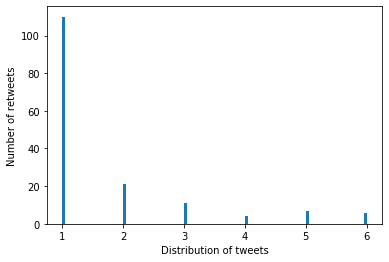

In [36]:
plt.hist(dist_retweets[40:], bins=100)
plt.xlabel('Distribution of tweets')
plt.ylabel('Number of retweets');

In [37]:
# Times favorited: 62% of tweets were not favorited and 14% were only favorited once. This means that, similar to
# the retweets, only a few (24%) are favorited twice or more times. It would be interesting to see if there is 
# a relationship between both 
twitter_firesv['times_favorited'].value_counts(normalize=True)

0      0.624074
1      0.141894
2      0.060992
3      0.034973
4      0.023210
         ...   
264    0.000035
248    0.000035
216    0.000035
168    0.000035
695    0.000035
Name: times_favorited, Length: 301, dtype: float64

Text(0, 0.5, 'Number of times retweeted')

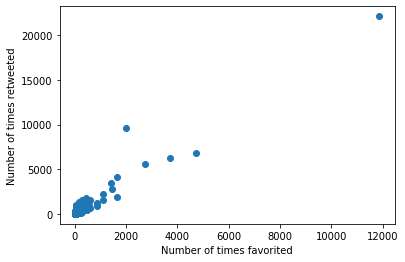

In [38]:
# Visualizing how they relate. They have a clear positive correlation. 
plt.scatter(twitter_firesv['times_retweeted'],twitter_firesv['times_favorited'])
plt.xlabel('Number of times favorited')
plt.ylabel('Number of times retweeted')

In [39]:
# Testing visualization excluding outliers 
withoutoutlier = twitter_firesv[(twitter_firesv['times_retweeted'] < 1000)
                                  & 
                                  (twitter_firesv['times_favorited'] < 1000)]

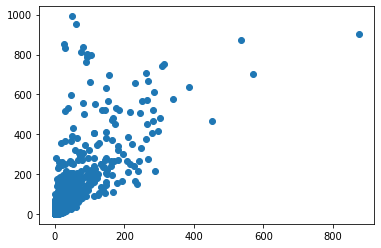

In [40]:
plt.scatter(withoutoutlier['times_retweeted'],withoutoutlier['times_favorited'])

**Pre-processing text data: Hashtags**

In [41]:
# Looking at the distribution of values under the hashtag column. 56% do not have any hashtag 
twitter_firesv['hashtags'].value_counts(normalize=True)

0                                                                                                    0.563924
#californiawildfires                                                                                 0.050212
#CaliforniaWildfires                                                                                 0.022192
#FoxNews                                                                                             0.009621
#wildfires                                                                                           0.004319
                                                                                                       ...   
#insurance #insurancecommissioner #California #californiawildfires #GettyFire #KincadeFire #sosad    0.000035
#ClimateChange #7ClimACTDetectives                                                                   0.000035
#PGE #California #AIMC #Business_News #Canada #Market_News                                           0.000035
#NDvsMich 

In [42]:
# I won't be able to vectorize the column if I have numeric values. Therefore, I am changing zeros to '0'. 
# twitter_firesv.loc[(twitter_firesv['hashtags'] == 0), 'hashtags'] == '0'
twitter_firesv.replace(0,'0', inplace=True)

In [43]:
hashtags = twitter_firesv['hashtags']

In [44]:
hashtags

0                                                        0
1        #californiawildfires #pge #FridayThoughts #Fri...
2                         #CaliforniaWildFires #GOPTaxScam
3                                                 #climate
4                                                        0
                               ...                        
28474            #wildfires #globalwarming #ethoslifestyle
28475                                          #California
28476                                                    0
28477                                                    0
28478                                                    0
Name: hashtags, Length: 28479, dtype: object

## Vectorizing and Modeling

In [51]:
# Vectorizing hashtags to get a sense of what's there beyond 'californiawildfires'. Instantiating vectorizer 
cvectorizer = CountVectorizer()

In [52]:
# Getting a word count sparse matrix  
word_count = cvectorizer.fit_transform(hashtags)

In [53]:
word_count.shape

(28479, 6967)

In [54]:
# Transforming the matrix into a dataframe
hashtags_df = pd.DataFrame(word_count.todense(), columns=cvectorizer.get_feature_names())

In [55]:
# Looking at the actual words 
hashtags_df.head()

,1010wins,10sand18s,10tanker,10tv,110envirojustice,113fire,118freeway,11alive,11thhour,12tribesofisrael,...,yrkkh,ytho,yum,yvr,yyc,zetatalk,zoedaniel,zombieapocalypse,zombies,zuckerberg
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
# Trying the TFIDF vectorizer. Instantiating so that it excludes words that appear in 
# less than 5 documents. Identified stopwords after grouping hashtags under 2 hashtags and 
# seeing they were repeated. 
tfidfvectorizer = TfidfVectorizer(stop_words=['californiawildfires',  'californiawildfire',
                                              'californiafires', 'californiafire','california',
                                              'wildfires', 'wildfire','calfire', 'calfires',
                                              'fire', 'fires', 'cafire', 'ca', 'cafires'] 
                                             , min_df= 5)

In [57]:
# Fitting it to the hashtags 
word_frequency = tfidfvectorizer.fit_transform(hashtags)

In [58]:
# Getting the number of words it identified above the threshold
word_frequency.shape

(28479, 775)

In [59]:
# Turning them into a dataframe
hashtagsfreq_df = pd.DataFrame(word_frequency.todense(), columns = tfidfvectorizer.get_feature_names())

In [60]:
# Looking at the actual words 
hashtagsfreq_df.head()

,25thamendmentnow,30seconds,46fire,7news,abc,abcnews,abubakralbaghdadi,acting,actnow,actonclimate,...,world,worldnews,worldseries,worstpresidentever,wtf,wuwei,wwe,wwg1wga,youtube,yrkkh
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
# Trying to get the most important keywords. But couldn't. The vocabulary attribute 
# gives me words and indices, but I do not understand how it is orgnized. It is not 
# alphabetical and it is not by level of importance (I don't think). 
words_dict = tfidfvectorizer.vocabulary_

In [62]:
# Turning the vocabulary into a dataframe to further explore the order of words 
frequent_words = pd.DataFrame.from_dict(words_dict, 
                                        orient='index', 
                                        columns=['Number'])

In [63]:
# Not much help here... 
frequent_words.sort_values('Number')

,Number
25thamendmentnow,0
30seconds,1
46fire,2
7news,3
abc,4
...,...
wuwei,770
wwe,771
wwg1wga,772
youtube,773


## Clustering by hashtag

In [64]:
from sklearn.cluster import KMeans

**Using KMeans clustering**: 

In [65]:
# Instantiating the model 
true_k = 20
kmmodel = KMeans(true_k, random_state=17)

In [66]:
# Fiting the model to our hashtags 
kmmodel.fit(word_frequency)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=20, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=17, tol=0.0001, verbose=0)

In [67]:
# Getting centroids. Wrote this based on: https://towardsdatascience.com/applying-machine-learning-to-classify-an-unsupervised-text-document-e7bb6265f52
hashtag_centroids = kmmodel.cluster_centers_.argsort()[:, ::-1]

In [68]:
# Trying to see the words. Got this and next loop from https://towardsdatascience.com/applying-machine-learning-to-classify-an-unsupervised-text-document-e7bb6265f52
terms = tfidfvectorizer.get_feature_names()

In [69]:
# Again, trying to see how the words are clustered
for i in range(true_k):
    print('Cluster %d:' % i),
    for ind in hashtag_centroids[i, :5]:
        print('%s' % terms[ind])

Cluster 0:
californiapoweroutage
californiaisburning
pge
easyfire
kincaidfire
Cluster 1:
pgepowershutoff
pgeshutoff
kincadefire
pge
pgeshutdown
Cluster 2:
climatecrisis
climatechange
climateemergency
greennewdeal
actonclimate
Cluster 3:
news
world
business
newsdigest
breaking
Cluster 4:
firefighters
firstresponders
californiaisburning
kincadefire
mariafire
Cluster 5:
pgeshutoff
pge
pgepowershutdown
pgeoutage
kinkaidfire
Cluster 6:
kincadefire
sonomacounty
kincade
kincadefires
sonomafire
Cluster 7:
lafires
gettyfire
lafd
lafire
firefighters
Cluster 8:
matthewmcconaughey
forestfires
mondaymotivation
firstresponders
losangeles
Cluster 9:
foxnews
tuckercarlson
pray
californiablackouts
newsom
Cluster 10:
climatechange
climateemergency
globalwarming
climate
climateaction
Cluster 11:
cawx
psps
kincadefire
firewx
sonoma
Cluster 12:
patriotpowerhour
brainimplants
reporates
russian
constitution
Cluster 13:
impeachtrump
theresistance
25thamendmentnow
lockhimup
maga
Cluster 14:
saddleridgefire
san

In [70]:
# Getting the cluster predictions
kmmodel.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [71]:
# Adding them as a column to the original dataframe 
twitter_firesv['hashtag_km_cluster'] = kmmodel.labels_

In [72]:
# Looking at the distribution of clusters. It is not good in the sense that it is highly
# ibalanced, but it seems to make sense as cluster 0 seems to pick up all fire-related
# tweets, cluster 1 all trump/political-related tweets, and cluster 2 all climate-related
# tweets. 
twitter_firesv['hashtag_km_cluster'].value_counts()

0     25607
6       368
9       302
10      300
15      289
16      180
11      179
4       175
3       173
2       171
19      169
5       126
13       76
17       76
14       75
1        73
12       47
7        44
18       37
8        12
Name: hashtag_km_cluster, dtype: int64

**Using DBSCAN:**

In [73]:
# Instantiating DBSCAN. I increased epsilon and minimum samples to get a somewhat reasonable
# amount of samples. With the standard parameters, I get 238 clusters. With these 
# we get 16 clusters. 
dbscanmodel = DBSCAN(eps=0.5, min_samples=20)

In [74]:
# Fitting DBSCAN
dbscanmodel.fit(word_frequency)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=20, n_jobs=None, p=None)

In [75]:
# Looking at the numbers of clusters. It created 238 clusters 
set(dbscanmodel.labels_)

{-1,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38}

In [76]:
twitter_firesv['hashtag_dbscan_cluster'] = dbscanmodel.labels_

In [77]:
twitter_firesv.head()

,date,text,username,id,tweet_to,times_retweeted,times_favorited,mentions,hashtags,addressee,hashtag_km_cluster,hashtag_dbscan_cluster
0,2019-11-29 23:10:01+00:00,California Wildfires Inspire Entrepreneur to C...,ReginaBanali,1200552524291411970,0,0,0,0,0,0 0,0,0
1,2019-11-29 22:49:52+00:00,NEW! ‘Rage for Justice Report - Episode 2 How ...,ConsumerWD,1200547453948162048,0,0,0,@PGE4Me @californiapuc,#californiawildfires #pge #FridayThoughts #Fri...,0 @PGE4Me @californiapuc,0,-1
2,2019-11-29 22:46:00+00:00,With the #CaliforniaWildFires fresh in our min...,ChangeTheLAUSD,1200546481494577153,GOPChairwoman,0,2,@KatieHill4CA,#CaliforniaWildFires #GOPTaxScam,GOPChairwoman @KatieHill4CA,0,-1
3,2019-11-29 22:08:21+00:00,#climate “Each degree of warming causes way mo...,ECOWARRIORSS,1200537005396037632,0,17,15,@yayitsrob,#climate,0 @yayitsrob,0,1
4,2019-11-29 22:08:07+00:00,The California wildfires should come to SoHo,jamesdotcom,1200536945711108104,0,1,19,0,0,0 0,0,0


## Clustering by addressee

**Using KMeans clustering**: 

In [78]:
# Looking at the addresee column 
twitter_firesv['addressee'].value_counts()

0 0                   19034
0 @YouTube              425
realDonaldTrump 0       250
0 @realDonaldTrump      186
0 @NBCNews              177
                      ...  
kelly_ramona 0            1
0 @VOAShaka               1
0 @CourtneyDeeren         1
ABC @GMB                  1
Zmarkus9 0                1
Name: addressee, Length: 4917, dtype: int64

In [79]:
# Isolating the column to pre-process it. 
addressees = twitter_firesv['addressee']

In [80]:
addressees

0                                0 0
1           0 @PGE4Me @californiapuc
2        GOPChairwoman @KatieHill4CA
3                       0 @yayitsrob
4                                0 0
                    ...             
28474                   0 @yayitsrob
28475                            0 0
28476                            0 0
28477                 AbdulElSayed 0
28478              0 @crooksandliars
Name: addressee, Length: 28479, dtype: object

In [81]:
# Instantiating the TFIDF vectorizer
tfidfvectorizerad = TfidfVectorizer()

In [82]:
# Fitting it to the addresees 
addressee_frequency = tfidfvectorizerad.fit_transform(addressees)

In [83]:
# Getting the number of words it identified 
addressee_frequency.shape

(28479, 4870)

In [84]:
addressee_frequency

<28479x4870 sparse matrix of type '<class 'numpy.float64'>'
	with 13266 stored elements in Compressed Sparse Row format>

In [85]:
# Turning them into a dataframe
addreseesfreq_df = pd.DataFrame(addressee_frequency.todense(), columns = tfidfvectorizerad.get_feature_names())

In [86]:
# Looking at the actual words 
addreseesfreq_df.head()

,0cean_sky,0sundance,10,1010wins,10monicawoods,10newswtsp,11,11alivenews,11thhour,1208snooks,...,zibalady1,zillowgroup,zimmerdiamonds,zmarkus9,zmcgowanfanclub,zonehaveninc,zsmitty11,zuleykalovers,zumapress,zyyral
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [179]:
# Trying to get the most important keywords. But couldn't. The vocabulary attribute 
# gives me words and indices, but I do not understand how it is orgnized. It is not 
# alphabetical and it is not by level of importance (I don't think). 
# Commenting this out to save space
# tfidfvectorizerad.vocabulary_

In [92]:
# Instantiating the model to cluster in 5 (we tried different k and this made the most 
# sense of all)
true_kad = 20
kmmodelad = KMeans(true_kad, random_state=17)

In [93]:
# Fiting the model to our addressees 
kmmodelad.fit(addressee_frequency)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=20, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=17, tol=0.0001, verbose=0)

In [94]:
# Getting centroids.
addressee_centroids = kmmodelad.cluster_centers_.argsort()[:, ::-1]

In [95]:
# Trying to see the words. 
addressesnames = tfidfvectorizerad.get_feature_names()

In [96]:
# Trying to see how the words are clustered
for i in range(true_kad):
    print('Cluster %d:' % i),
    for ind in addressee_centroids[i, :5]:
        print('%s' % addressesnames[ind])

Cluster 0:
johncornyn
geigernews
zyyral
gadinbc
g1
Cluster 1:
latimes
pge4me
aoc
cal_fire
kamalaharris
Cluster 2:
usatoday
realdonaldtrump
twittermoments
potus
gabriel_mann
Cluster 3:
abc
realdonaldtrump
reevewill
mattgutmanabc
lookner
Cluster 4:
leahstokes
democracynow
ucsantabarbara
sunrisemvmt
womenalsoknow
Cluster 5:
youtube
rubinreport
drvox
redtraccoon
realdonaldtrump
Cluster 6:
abc7
realdonaldtrump
abc7alexcheney
marston4ca42
calfire
Cluster 7:
nbcnews
realdonaldtrump
potus
gop
gabriela__gs
Cluster 8:
googlenews
tomleykis
therealdvorak
tesla
whitehouse
Cluster 9:
npr
npratc
conorsen
berkeleyside
kcbsradio
Cluster 10:
realdonaldtrump
potus
gop
speakerpelosi
whitehouse
Cluster 11:
nypost
gabriela__gs
futuritynews
fwcallaway
g1
Cluster 12:
gavinnewsom
realdonaldtrump
pge4me
speakerpelosi
cagovernor
Cluster 13:
cbspolitics
realdonaldtrump
morgfair
gaelle_mg
g_meslin
Cluster 14:
laist
kpcc
exposwillreturn
ryfons
zyyral
Cluster 15:
cbsnews
climatehuman
cbsthismorning
kpixtv
cbsla
Clus

In [97]:
# Getting the cluster predictions
kmmodelad.labels_

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [98]:
# Adding them as a column to the original dataframe 
twitter_firesv['addressee_km_cluster'] = kmmodelad.labels_

In [99]:
# Looking at the distribution of clusters. It is not good in the sense that it is highly
# ibalanced, but it seems to make sense as cluster 0 seems to pick up all fire-related
# tweets, cluster 1 all trump/political-related tweets, and cluster 2 all climate-related
# tweets. 
twitter_firesv['addressee_km_cluster'].value_counts()

1     26303
10      491
5       430
12      252
3       213
7       190
2       119
8       119
6        71
19       63
13       57
15       39
17       37
11       34
4        12
14       12
9        12
18       11
16        9
0         5
Name: addressee_km_cluster, dtype: int64

**Using DBSCAN:**

In [100]:
# Instantiating DBSCAN. I increased epsilon and minimum samples to get a somewhat reasonable
# amount of samples. With the standard parameters, I get 241 clusters. With these 
# we get 21 clusters. 
dbscanmodelad = DBSCAN(eps=0.5, min_samples=30)

In [101]:
# Fitting DBSCAN
dbscanmodelad.fit(addressee_frequency)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=30, n_jobs=None, p=None)

In [102]:
# Looking at the numbers of clusters. 
set(dbscanmodelad.labels_)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}

In [103]:
twitter_firesv['addresse_dbscan_cluster'] = dbscanmodelad.labels_

In [104]:
twitter_firesv.head()

,date,text,username,id,tweet_to,times_retweeted,times_favorited,mentions,hashtags,addressee,hashtag_km_cluster,hashtag_dbscan_cluster,addressee_km_cluster,addresse_dbscan_cluster
0,2019-11-29 23:10:01+00:00,California Wildfires Inspire Entrepreneur to C...,ReginaBanali,1200552524291411970,0,0,0,0,0,0 0,0,0,1,0
1,2019-11-29 22:49:52+00:00,NEW! ‘Rage for Justice Report - Episode 2 How ...,ConsumerWD,1200547453948162048,0,0,0,@PGE4Me @californiapuc,#californiawildfires #pge #FridayThoughts #Fri...,0 @PGE4Me @californiapuc,0,-1,1,-1
2,2019-11-29 22:46:00+00:00,With the #CaliforniaWildFires fresh in our min...,ChangeTheLAUSD,1200546481494577153,GOPChairwoman,0,2,@KatieHill4CA,#CaliforniaWildFires #GOPTaxScam,GOPChairwoman @KatieHill4CA,0,-1,1,-1
3,2019-11-29 22:08:21+00:00,#climate “Each degree of warming causes way mo...,ECOWARRIORSS,1200537005396037632,0,17,15,@yayitsrob,#climate,0 @yayitsrob,0,1,1,-1
4,2019-11-29 22:08:07+00:00,The California wildfires should come to SoHo,jamesdotcom,1200536945711108104,0,1,19,0,0,0 0,0,0,1,0


## Clustering by tweet

In [105]:
# Looking at the tweet column 
twitter_firesv['text']

0        California Wildfires Inspire Entrepreneur to C...
1        NEW! ‘Rage for Justice Report - Episode 2 How ...
2        With the #CaliforniaWildFires fresh in our min...
3        #climate “Each degree of warming causes way mo...
4             The California wildfires should come to SoHo
                               ...                        
28474    California wildfires have quintupled in size o...
28475    How can you remind your clients of your value ...
28476    rich people be like climate change is bad act ...
28477    This is how the California wildfires started, ...
28478    Domestic Terrorist Intentionally Sets Californ...
Name: text, Length: 28479, dtype: object

In [106]:
tweets = twitter_firesv['text']

**TFIDF Vectorizing using ngram(1,1)**: 

In [107]:
# Instantiating the vectorizer with ngram(1,1) to start. Will subsequently try a couple of 
# ngrams. 
tfidfvect_text = TfidfVectorizer(
    strip_accents='ascii', 
    stop_words = ['californiawildfires','californiawildfire','californiafires', 
    'californiafire','california','wildfires', 'wildfire','calfire', 'calfires','fire', 
    'fires', 'cafire', 'ca', 'cafires', 'it', 'its', 'itself', 'what', 'which', 'whom', 'this',
    'that', 'these', 'those','a','an','the','and','but','or','as','of','at','by','for',
    'with', 'into','to','up','down','in','on','off', 'such', 'so', 'than', 'too', 'very', 'http', 
    'https', 'www', 'com', 's', 'e','is','you','are','i','be','all','we','our','your','if','re'],
    token_pattern = r'[a-zA-Z]+', 
    min_df = 3,
    ngram_range=(1,1)
)

In [108]:
# Fitting the vectorizer
tweetword_freq1 = tfidfvect_text.fit_transform(tweets)

In [109]:
# Setting the sparse matrix as a dataframe  
tweetwordfreq_df1= pd.DataFrame(tweetword_freq1.todense(), columns = tfidfvect_text.get_feature_names())

In [110]:
tweetwordfreq_df1.shape

(28479, 9473)

In [111]:
# Looking at the words 
tweetwordfreq_df1.head()

,TM,aa,aag,aaidh,aaidkx,aaiennp,aajmp,aajocpm,aajritf,aajs,...,zp,zpr,zr,zrhaq,zrrczr,zta,ztpr,zuckerberg,zuma,zz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [178]:
# Commenting this out to save space, but this is the vocabulary counts
# tfidfvect_text.vocabulary_

**KMeans Clustering using TFIDFVec ngram 1,1:**

In [113]:
# Instantiating the model. Smaller k yield very imbalanced classes. We tried different 
# k values and this one yielded clusters that made most sense. 
true_ktweet = 20
kmmodeltweet1 = KMeans(true_ktweet, random_state=17)

In [114]:
# Fiting the model to our addressees 
kmmodeltweet1.fit(tweetword_freq1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=20, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=17, tol=0.0001, verbose=0)

In [115]:
# Getting centroids.
tweet_centroids1 = kmmodeltweet1.cluster_centers_.argsort()[:, ::-1]

In [116]:
# Trying to see the words. 
tweetwords1 = tfidfvect_text.get_feature_names()

In [117]:
# Trying to see how the words are clustered
for i in range(true_ktweet):
    print('Cluster %d:' % i),
    for ind in tweet_centroids1[i, :10]:
        print('%s' % tweetwords1[ind])

Cluster 0:
from
power
pg
have
climate
amp
help
news
how
via
Cluster 1:
fight
no
funds
ll
more
trump
says
he
federal
cut
Cluster 2:
funding
cut
trump
fema
ordered
threatens
says
has
he
us
Cluster 3:
new
live
winds
blaze
library
reagan
strong
news
kincade
amid
Cluster 4:
cena
john
responders
first
battling
k
donating
donates
pledges
fighting
Cluster 5:
los
angeles
photos
from
homes
threaten
holman
jenkins
revolt
sent
Cluster 6:
southern
deaths
three
tied
authorities
unchecked
burning
dead
following
linked
Cluster 7:
about
trump
not
climate
he
t
how
know
pelosi
talking
Cluster 8:
more
event
historic
wind
evacuations
shutoffs
power
force
after
foxnews
Cluster 9:
force
emergency
statewide
evacuate
evacuations
evacuation
winds
trigger
nearly
declared
Cluster 10:
bbc
warned
possible
millions
news
canada
world
power
cut
us
Cluster 11:
firefighters
battle
illustrate
exhausting
against
thank
dramatic
inmate
facing
light
Cluster 12:
erupt
wine
country
burn
la
angeles
los
rh
dlvr
aajs
Cluster 13:


In [118]:
# Getting the cluster predictions
kmmodeltweet1.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [119]:
# Adding them as a column to the original dataframe 
twitter_firesv['tweet_km_cluster_ngram1_1'] = kmmodeltweet1.labels_

In [120]:
# Looking at the distribution of clusters. It is not good in the sense that it is highly
# ibalanced, but it seems to make sense as cluster 0 seems to pick up all fire-related
# tweets, cluster 1 all trump/political-related tweets, and cluster 2 all climate-related
# tweets. 
twitter_firesv['tweet_km_cluster_ngram1_1'].value_counts()

0     17778
7      1243
3       971
14      894
17      859
5       792
2       672
18      640
1       623
6       618
9       577
15      543
10      407
16      398
19      290
8       282
4       249
11      234
13      221
12      188
Name: tweet_km_cluster_ngram1_1, dtype: int64

**TFIDF Vectorizing using ngram(2,2)**: 

In [121]:
# Instantiating the vectorizer with ngram(1,1) to start. Will subsequently try a couple of 
# ngrams. 
tfidfvect_text2 = TfidfVectorizer(
    strip_accents='ascii', 
    stop_words = ['californiawildfires','californiawildfire','californiafires', 
    'californiafire','california','wildfires', 'wildfire','calfire', 'calfires','fire', 
    'fires', 'cafire', 'ca', 'cafires', 'it', 'its', 'itself', 'what', 'which', 'whom', 'this',
    'that', 'these', 'those','a','an','the','and','but','or','as','of','at','by','for',
    'with', 'into','to','up','down','in','on','off', 'such', 'so', 'than', 'too', 'very', 'http', 
    'https', 'www', 'com', 's', 'e','is','you','are','i','be','all','we','our','your','if','re'],
    token_pattern = r'[a-zA-Z]+', 
    min_df = 3,
    ngram_range=(2,2)
)

In [122]:
# Fitting the vectorizer
tweetword_freq2 = tfidfvect_text2.fit_transform(tweets)

In [123]:
# Setting the sparse matrix as a dataframe  
tweetwordfreq_df2= pd.DataFrame(tweetword_freq2.todense(), columns = tfidfvect_text2.get_feature_names())

In [124]:
tweetwordfreq_df2.shape

(28479, 16555)

In [125]:
# Looking at the words 
tweetwordfreq_df2.head()

,aa news,aag aag,aaidh ocid,aaidkx ocid,aaiennp ocid,aajmp d,aajocpm ocid,aajritf ocid,aajs ae,aajuzbb ocid,...,znw ogski,zone evacuation,zones now,zpr io,zrhaq via,zta via,ztpr qtwayoaqdj,zuma october,zuma wire,zz news
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [126]:
# For seeing the vocabulary, but commented out to save space
# tfidfvect_text2.vocabulary_

**KMeans Clustering using TFIDFVec ngram 2,2:**

In [127]:
# Instantiating the model. Smaller k yield very imbalanced classes. We tried different 
# k values and this one yielded clusters that made most sense. 
true_ktweet2 = 20
kmmodeltweet2 = KMeans(true_ktweet2, random_state=17)

In [128]:
# Fiting the model to our addressees 
kmmodeltweet2.fit(tweetword_freq2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=20, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=17, tol=0.0001, verbose=0)

In [129]:
# Getting centroids.
tweet_centroids2 = kmmodeltweet2.cluster_centers_.argsort()[:, ::-1]

In [130]:
# Trying to see the words. 
tweetwords2 = tfidfvect_text2.get_feature_names()

In [131]:
# Trying to see how the words are clustered
for i in range(true_ktweet2):
    print('Cluster %d:' % i),
    for ind in tweet_centroids2[i, :10]:
        print('%s' % tweetwords2[ind])

Cluster 0:
have done
would have
everything have
electra oann
loss property
dating back
fema gov
control have
federal control
under federal
Cluster 1:
millions warned
warned possible
possible power
power cut
cut bbc
bbc news
us canada
world us
news world
news millions
Cluster 2:
winery rebuild
maria evacuations
lifted winery
nation maria
evacuations lifted
story news
usatoday story
news nation
fight usatoday
ll cut
Cluster 3:
threatens cut
trump threatens
federal funding
cut federal
us funding
cut us
funding abc
abc news
cut funding
via abc
Cluster 4:
los angeles
climate change
bit ly
first responders
amp utm
thousands evacuated
via youtube
wine country
power outages
pg amp
Cluster 5:
menace reagan
library getty
twin southern
southern menace
museum homes
getty museum
reagan library
homes dlvr
update twin
homes reuters
Cluster 6:
threatens pull
pull federal
federal aid
trump threatens
aid nbcnews
aid n
politics donald
nbcnews politics
trump trump
donald trump
Cluster 7:
signal arrival
ar

In [132]:
# Getting the cluster predictions
kmmodeltweet2.labels_

array([4, 4, 4, ..., 4, 4, 4], dtype=int32)

In [133]:
# Adding them as a column to the original dataframe 
twitter_firesv['tweet_km_cluster_ngram2_2'] = kmmodeltweet2.labels_

In [134]:
# Looking at the distribution of clusters. It is not good in the sense that it is highly
# ibalanced, but it seems to make sense as cluster 0 seems to pick up all fire-related
# tweets, cluster 1 all trump/political-related tweets, and cluster 2 all climate-related
# tweets. 
twitter_firesv['tweet_km_cluster_ngram2_2'].value_counts()

4     25193
3       696
17      394
19      351
6       348
12      272
1       249
7       204
10      143
2       134
11       95
15       87
13       75
14       65
8        50
9        37
5        34
18       31
16       11
0        10
Name: tweet_km_cluster_ngram2_2, dtype: int64

**DBSCAN Clustering using TFIDFVec ngram 2,2:**

In [135]:
# Instantiating the model. The standard parameters give us 600+ clusters. These parameters 
# give us 29
dbscan_tweet = DBSCAN(eps=0.5, min_samples=70)

In [136]:
# Fiting the model to our addressees 
dbscan_tweet.fit(tweetword_freq2)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=70, n_jobs=None, p=None)

In [137]:
# Looking at the numbers of clusters. 
set(dbscan_tweet.labels_)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}

In [138]:
# Adding a colum with the clusters 
twitter_firesv['tweets_dbscan_cluster'] = dbscan_tweet.labels_

In [139]:
twitter_firesv.head()

,date,text,username,id,tweet_to,times_retweeted,times_favorited,mentions,hashtags,addressee,hashtag_km_cluster,hashtag_dbscan_cluster,addressee_km_cluster,addresse_dbscan_cluster,tweet_km_cluster_ngram1_1,tweet_km_cluster_ngram2_2,tweets_dbscan_cluster
0,2019-11-29 23:10:01+00:00,California Wildfires Inspire Entrepreneur to C...,ReginaBanali,1200552524291411970,0,0,0,0,0,0 0,0,0,1,0,0,4,-1
1,2019-11-29 22:49:52+00:00,NEW! ‘Rage for Justice Report - Episode 2 How ...,ConsumerWD,1200547453948162048,0,0,0,@PGE4Me @californiapuc,#californiawildfires #pge #FridayThoughts #Fri...,0 @PGE4Me @californiapuc,0,-1,1,-1,0,4,-1
2,2019-11-29 22:46:00+00:00,With the #CaliforniaWildFires fresh in our min...,ChangeTheLAUSD,1200546481494577153,GOPChairwoman,0,2,@KatieHill4CA,#CaliforniaWildFires #GOPTaxScam,GOPChairwoman @KatieHill4CA,0,-1,1,-1,0,4,-1
3,2019-11-29 22:08:21+00:00,#climate “Each degree of warming causes way mo...,ECOWARRIORSS,1200537005396037632,0,17,15,@yayitsrob,#climate,0 @yayitsrob,0,1,1,-1,0,4,-1
4,2019-11-29 22:08:07+00:00,The California wildfires should come to SoHo,jamesdotcom,1200536945711108104,0,1,19,0,0,0 0,0,0,1,0,0,4,0


## Bringing in Bot Rating Data

### We decided to do some analysis of bot likelihood compared to the clusters. This way, if particular clusters were associated with high bot activity, agencies would know that certain information could be spread fast and work to counter it. 

In [141]:
# Saving the clusters into a csv file
twitter_firesv.to_csv('./data/twitter_clusters.csv', index=False)

In [142]:
# Reading in data with botrating 
twitter_botrating = pd.read_csv('./data/twitter_preprocessed_all.csv')

In [143]:
# Looking at the data 
twitter_botrating.head()

,date,times_retweeted,times_favorited,bot_rating,words
0,2019-10-28 16:04:00+00:00,0,1,0.005364,AMPMUZIC #CaliforniaFires #californiawildfires...
1,2019-11-12 03:06:00+00:00,2,1,0.014544,"dwatchnews nam Rebirth, angst and the 'new n..."
2,2019-11-03 20:10:28+00:00,0,0,0.036578,WaterSolarWind Trump melts down on Pelosi du...
3,2019-10-26 08:48:42+00:00,2,2,0.097414,BombayHeadlines #CaliforniaWildfire #californi...
4,2019-11-02 21:57:37+00:00,1,1,0.008751,studentveronica California Wildfires Signal ...


In [144]:
# Separating the username
twitter_botrating['username'] = twitter_botrating['words'].str.split().str[0].str.strip()

In [145]:
# Looking again 
twitter_botrating.head()

,date,times_retweeted,times_favorited,bot_rating,words,username
0,2019-10-28 16:04:00+00:00,0,1,0.005364,AMPMUZIC #CaliforniaFires #californiawildfires...,AMPMUZIC
1,2019-11-12 03:06:00+00:00,2,1,0.014544,"dwatchnews nam Rebirth, angst and the 'new n...",dwatchnews
2,2019-11-03 20:10:28+00:00,0,0,0.036578,WaterSolarWind Trump melts down on Pelosi du...,WaterSolarWind
3,2019-10-26 08:48:42+00:00,2,2,0.097414,BombayHeadlines #CaliforniaWildfire #californi...,BombayHeadlines
4,2019-11-02 21:57:37+00:00,1,1,0.008751,studentveronica California Wildfires Signal ...,studentveronica


In [146]:
# Merging botrating and cluster data frames 
twitter_firesall = pd.merge(twitter_firesv, twitter_botrating, on ='username')

In [147]:
twitter_firesall.head()

,date_x,text,username,id,tweet_to,times_retweeted_x,times_favorited_x,mentions,hashtags,addressee,...,addressee_km_cluster,addresse_dbscan_cluster,tweet_km_cluster_ngram1_1,tweet_km_cluster_ngram2_2,tweets_dbscan_cluster,date_y,times_retweeted_y,times_favorited_y,bot_rating,words
0,2019-11-29 23:10:01+00:00,California Wildfires Inspire Entrepreneur to C...,ReginaBanali,1200552524291411970,0,0,0,0,0,0 0,...,1,0,0,4,-1,2019-11-29 23:10:01+00:00,0,0,0.041425,ReginaBanali California Wildfires Inspire En...
1,2019-11-29 22:49:52+00:00,NEW! ‘Rage for Justice Report - Episode 2 How ...,ConsumerWD,1200547453948162048,0,0,0,@PGE4Me @californiapuc,#californiawildfires #pge #FridayThoughts #Fri...,0 @PGE4Me @californiapuc,...,1,-1,0,4,-1,2019-11-29 22:49:52+00:00,0,0,0.036578,ConsumerWD #californiawildfires #pge #FridayTh...
2,2019-11-29 22:49:52+00:00,NEW! ‘Rage for Justice Report - Episode 2 How ...,ConsumerWD,1200547453948162048,0,0,0,@PGE4Me @californiapuc,#californiawildfires #pge #FridayThoughts #Fri...,0 @PGE4Me @californiapuc,...,1,-1,0,4,-1,2019-10-31 16:53:34+00:00,2,1,0.003457,ConsumerWD #HillsideFire #46Fire #kinkaidfire ...
3,2019-11-29 22:49:52+00:00,NEW! ‘Rage for Justice Report - Episode 2 How ...,ConsumerWD,1200547453948162048,0,0,0,@PGE4Me @californiapuc,#californiawildfires #pge #FridayThoughts #Fri...,0 @PGE4Me @californiapuc,...,1,-1,0,4,-1,2019-11-13 01:24:09+00:00,1,2,0.003457,ConsumerWD #californiawildfires #tuesdayvibes ...
4,2019-11-13 01:24:09+00:00,What do we need to do as an alternative to @PG...,ConsumerWD,1194425683709059073,0,1,2,@PGE4Me @RaisingHellNow,#californiawildfires #tuesdayvibes,0 @PGE4Me @RaisingHellNow,...,1,-1,0,4,-1,2019-11-29 22:49:52+00:00,0,0,0.036578,ConsumerWD #californiawildfires #pge #FridayTh...


In [148]:
# Dropping repeated columns 
twitter_firesall1 = twitter_firesall.drop(columns=['date_y', 'times_retweeted_y','times_favorited_y', 'words'])

In [149]:
# Taking a final look at the data 
twitter_firesall = twitter_firesall.to_csv('./data/final_final_final_final_dataframe.csv')

In [150]:
# Checking data types 
type(twitter_firesall1)

pandas.core.frame.DataFrame

In [151]:
twitter_firesall1.head(1)

,date_x,text,username,id,tweet_to,times_retweeted_x,times_favorited_x,mentions,hashtags,addressee,hashtag_km_cluster,hashtag_dbscan_cluster,addressee_km_cluster,addresse_dbscan_cluster,tweet_km_cluster_ngram1_1,tweet_km_cluster_ngram2_2,tweets_dbscan_cluster,bot_rating
0,2019-11-29 23:10:01+00:00,California Wildfires Inspire Entrepreneur to C...,ReginaBanali,1200552524291411970,0,0,0,0,0,0 0,0,0,1,0,0,4,-1,0.041425


In [152]:
# Looking at the average bot rating for hashtag clusters using kmeans clustering
hashtag_botrkm = twitter_firesall1.groupby('hashtag_km_cluster')['bot_rating'].mean()

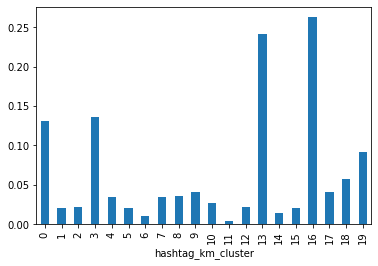

In [153]:
hashtag_botrkm.plot.bar()

In [154]:
# Looking at the average bot rating for hashtag clusters using dbscan clustering
hashtag_botdb = twitter_firesall1.groupby('hashtag_dbscan_cluster')['bot_rating'].mean()

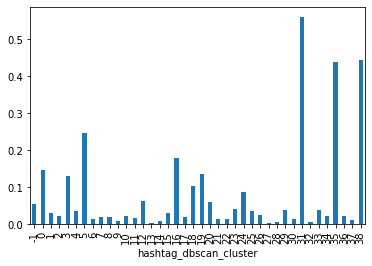

In [155]:
hashtag_botdb.plot.bar()

In [156]:
# Looking at the average bot rating for addressee clusters using kmeans clustering
addresee_botkm = twitter_firesall1.groupby('addressee_km_cluster')['bot_rating'].mean()

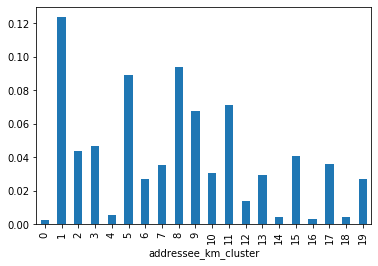

In [157]:
addresee_botkm.plot.bar()

In [158]:
# Looking at the average bot rating for addressee clusters using dbscan clustering
addresee_botdbscan = twitter_firesall1.groupby('addresse_dbscan_cluster')['bot_rating'].mean()

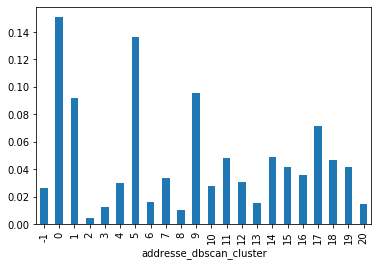

In [159]:
addresee_botdbscan.plot.bar()

In [160]:
# Looking at the average bot rating for tweet text clusters using kmeans clustering on ngram:1,1
tweetkm11_bot = twitter_firesall1.groupby('tweet_km_cluster_ngram1_1')['bot_rating'].mean()

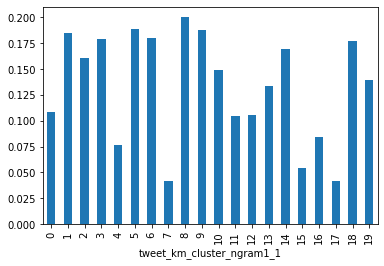

In [161]:
tweetkm11_bot.plot.bar()

In [162]:
# Looking at the average bot rating for tweet text clusters using kmeans clustering on ngram:2,2
twitterkm22_bot = twitter_firesall1.groupby('tweet_km_cluster_ngram2_2')['bot_rating'].mean()

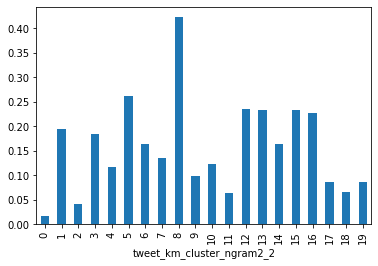

In [163]:
twitterkm22_bot.plot.bar()

In [164]:
# Looking at the average bot rating for tweet text clusters using dbscan clustering on ngram:1,1
twitterdb22_bot = twitter_firesall1.groupby('tweets_dbscan_cluster')['bot_rating'].mean()

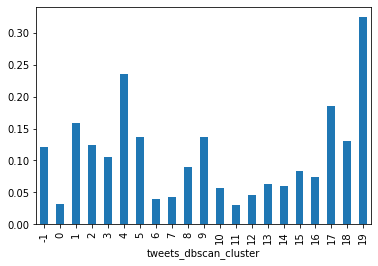

In [165]:
twitterdb22_bot.plot.bar()

In [166]:
# Looking 
twitterclustered19 = twitter_firesall1[twitter_firesall1['tweets_dbscan_cluster'] == 19]

In [167]:
twitc19text = twitterclustered19['text']

In [168]:
# Instantiating the vectorizer with ngram(1,1) to start. Will subsequently try a couple of 
# ngrams. 
tfidfvec = TfidfVectorizer(
    strip_accents='ascii', 
    stop_words = ['californiawildfires','californiawildfire','californiafires', 
    'californiafire','california','wildfires', 'wildfire','calfire', 'calfires','fire', 
    'fires', 'cafire', 'ca', 'cafires', 'it', 'its', 'itself', 'what', 'which', 'whom', 'this',
    'that', 'these', 'those','a','an','the','and','but','or','as','of','at','by','for',
    'with', 'into','to','up','down','in','on','off', 'such', 'so', 'than', 'too', 'very', 'http', 
    'https', 'www', 'com', 's', 'e','is','you','are','i','be','all','we','our','your','if','re'],
    token_pattern = r'[a-zA-Z]+', 
    min_df = 3,
    ngram_range=(2,2)
)

In [169]:
# Fitting the vectorizer
fittedtweets = tfidfvec.fit_transform(twitc19text)

In [170]:
# Setting the sparse matrix as a dataframe  
fittedtweets_df = pd.DataFrame(fittedtweets.todense(), columns = tfidfvec.get_feature_names())

In [171]:
fittedtweets_df.shape

(115, 15)

In [172]:
# Looking at the words 
fittedtweets_df.head()

,acres burned,burned dlvr,dlvr rfzx,dlvr rfzydn,dlvr rfzyj,dlvr rfzyjb,dlvr rfzyjm,dlvr rfzyks,dlvr rfzykw,dlvr rfzyl,dlvr rfzylr,dlvr rg,evacuated k,k acres,thousands evacuated
0,0.447214,0.447214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.447214,0.447214,0.447214
1,0.447214,0.447214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.447214,0.447214,0.447214
2,0.447214,0.447214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.447214,0.447214,0.447214
3,0.447214,0.447214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.447214,0.447214,0.447214
4,0.447214,0.447214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.447214,0.447214,0.447214


**KMeans Clustering using TFIDFVec ngram 2,2:**

In [173]:
# Instantiating the model. Smaller k yield very imbalanced classes. We tried different 
# k values and this one yielded clusters that made most sense. 
true_kfittedtweet = 2
kmmodelfittedtweet = KMeans(true_kfittedtweet, random_state=17)

In [174]:
# Fiting the model to our addressees 
kmmodelfittedtweet.fit(fittedtweets)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=17, tol=0.0001, verbose=0)

In [175]:
# Getting centroids.
fittedtweet_centroids = kmmodelfittedtweet.cluster_centers_.argsort()[:, ::-1]

In [176]:
# Trying to see the words. 
fittedtweetswords = tfidfvec.get_feature_names()

In [177]:
# Trying to see how the words are clustered
for i in range(true_kfittedtweet):
    print('Cluster %d:' % i),
    for ind in fittedtweet_centroids[i, :20]:
        print('%s' % fittedtweetswords[ind])

Cluster 0:
thousands evacuated
k acres
evacuated k
burned dlvr
acres burned
dlvr rg
dlvr rfzylr
dlvr rfzyl
dlvr rfzyks
dlvr rfzyjm
dlvr rfzyjb
dlvr rfzyj
dlvr rfzydn
dlvr rfzx
dlvr rfzykw
Cluster 1:
dlvr rfzykw
thousands evacuated
k acres
evacuated k
burned dlvr
acres burned
dlvr rg
dlvr rfzylr
dlvr rfzyl
dlvr rfzyks
dlvr rfzyjm
dlvr rfzyjb
dlvr rfzyj
dlvr rfzydn
dlvr rfzx


In [1]:
### Reference: This article was used to help with some of the clustering code: https://towardsdatascience.com/applying-machine-learning-to-classify-an-unsupervised-text-document-e7bb6265f52